# Инициализация

In [1]:
import torch
from PIL import Image
import numpy as np
import pandas as pd
import os
from torchvision import transforms
import random


# Информация об авторе проекта:
#  ФИО: Погорельских Константин Владимирович
#  ВУЗ: ЧОУ ВО «Московский университет им. С.Ю. Витте»
#  Специальность: Прикладная информатика [09.03.03] Бакалавр
#  Факультет: Информационных технологий
#  Специализация / Профиль подготовки: Искусственный интеллект и анализ данных
#  Учебная группа: ИД 23.3/Б3-21


# Устройство (CPU или GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ClagnoscoDataset(torch.utils.data.Dataset):
    '''
    Класс для загрузки изображений.
    '''
    def __init__(self):
        self.base_dir = r"C:\!project-dataset"
        metadata_path = os.path.join(self.base_dir, "metadata.csv")
        self.data = pd.read_csv(metadata_path)
        self.buckets = self.bucketize()
        self.bucket_count = self.bucket_counting()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        uid = self.data.loc[idx, 'uid']
        image_resize_path = os.path.join(self.base_dir, 'images_resize', f"{uid}.jpg")
        image_square_path = os.path.join(self.base_dir, 'images_square', f"{uid}.jpg")

        image = Image.open(image_resize_path)
        image_square = Image.open(image_square_path)

        return {
            'uid': uid,
            'image': image,
            'image_width': self.data.loc[idx, 'image_width'],
            'image_height': self.data.loc[idx, 'image_height'],
            'image_square': image_square,
        }
    
    def bucketize(self):
        '''
        Разделение на бакеты по разрешению изображения.
        '''
        buckets = dict()
        for idx, row in self.data.iterrows():
            key = (row['image_width'], row['image_height'])
            if key not in buckets:
                buckets[key] = []
            buckets[key].append(idx)
        self.buckets = buckets
        return buckets
    
    def bucket_counting(self):
        '''
        Подсчёт количества изображений в каждом бакете.
        '''
        return sorted([(i, len(j)) for i, j in self.buckets.items()], key=lambda x: -x[1])
    
    def random_splitting_batching_buckets(self, percent=0.75, seed=42, batch_size=-1, max_batch_size=32):
        '''
        Разделение на 2 выборки (тренировочную и тестовую) с батчами. 0 и 1 на самом деле работают.
        
        - batch_size = -1 -- Размер бытча: Автоматическое гармоническое среднее (по умолчанию)
        - batch_size = 0  -- Размер бытча: Без батчей
        '''
        bucket_count = [i[1] for i in self.bucket_count]

        def harmonic_mean(array, percent, max_batch_size):
            len_array = len(array)
            if percent == 0 or percent == 1:
                batch_size = round(len_array / sum(1/x for x in array if x > 0))
            else:
                batch_size = round(len_array / sum(1/(x*percent) for x in array if x > 0))
            if batch_size == 0:
                batch_size = 1
            if batch_size > max_batch_size:
                batch_size = max_batch_size
            return batch_size

        rev_percent = 1 - percent
        if batch_size == -1:
            batch_size1 = harmonic_mean(bucket_count, percent, max_batch_size)
            batch_size2 = harmonic_mean(bucket_count, rev_percent, max_batch_size)
        else:
            if batch_size > max_batch_size:
                batch_size = max_batch_size
            batch_size1 = batch_size
            batch_size2 = batch_size
        
        part1 = []
        part2 = []
        for wh, bucket in self.buckets.items():
            random.seed(seed)
            random.shuffle(bucket)
            splitting_part = int(len(bucket) * rev_percent)

            this_split = bucket[splitting_part:]
            this_split_len = len(this_split)
            if this_split_len != 0:
                if batch_size1 != 0:
                    for i in range(0, this_split_len, batch_size1):
                        part1.append([wh, this_split[i:i+batch_size1]])
                else:
                    part1.append([wh, this_split])
            
            this_split = bucket[:splitting_part]
            this_split_len = len(this_split)
            if this_split_len != 0:
                if batch_size2 != 0:
                    for i in range(0, this_split_len, batch_size2):
                        part2.append([wh, this_split[i:i+batch_size2]])
                else:
                    part2.append([wh, this_split])
            seed += 1
        random.seed(seed + 1)
        random.shuffle(part1)
        random.seed(seed + 2)
        random.shuffle(part2)
        random.seed()
        return part1, part2


class TransformedClagnoscoDataset(torch.utils.data.Dataset):
    '''
    Изображения преобразованные в тензоры.
    '''
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
            ])
        else:
            self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        # Использование ToTensor() для преобразования в тензор
        if self.transform:
            item['image'] = self.transform(item['image'])
            item['image_square'] = self.transform(item['image_square'])
        
        return item


def iterate_batched_buckets(transformed_dataset, batched_buckets):
    """
    Входные данные:
        - transformed_dataset: экземпляр TransformedClagnoscoDataset
        - batched_buckets: список [(ширина, высота), [idx1, idx2, ...]] батчей
    
    Выходные данные (yield):
        - batch: словарь элементов батча
        - resolution: (ширина, высота)
    """
    for resolution, index_batch in batched_buckets:
        batch_items = [transformed_dataset[i] for i in index_batch]

        batch = {}
        for key in batch_items[0]:
            values = [item[key] for item in batch_items]
            if isinstance(values[0], torch.Tensor):
                try:
                    batch[key] = torch.stack(values)
                except Exception:
                    batch[key] = values
            else:
                batch[key] = values

        yield batch, resolution

def batch_buckets_to_list(batches):
    """
    Преобразует батчи в список индексов.
    """
    list_idxs = []
    for batch in [i[1] for i in batches]:
        list_idxs.extend(batch)
    return list_idxs


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import os
import requests
import tempfile
if __name__ == "__main__":
    from tqdm import tqdm
else:
    from tqdm.notebook import tqdm


# Информация об авторе проекта:
#  ФИО: Погорельских Константин Владимирович
#  Специальность: Прикладная информатика [09.03.03] Бакалавр
#  Факультет: Информационных технологий
#  Специализация / Профиль подготовки: Искусственный интеллект и анализ данных
#  Учебная группа: ИД 23.3/Б3-21


# Папка для сохранения моделей
SAVE_FOLDER = "models/"


class ClagnoscoEncoder(nn.Module):
    '''
    Вход: Тензорные изображения в батче (B, 3, H, W)

    Выход: Латентные векторы в батче (B, 4096)
    '''
    def __init__(
        self,
        latent_dim=4096,
        backbone_channels=1024,
        negative_slope=0.01
    ):
        super().__init__()
        self.latent_dim_size = latent_dim 

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope, inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=backbone_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(backbone_channels),
            nn.LeakyReLU(negative_slope, inplace=True),
        )

        self.pool = nn.AdaptiveAvgPool2d((4, 4))  # Output: (B, backbone_channels, 4, 4)

        self.lin = nn.Sequential(
            nn.Linear(backbone_channels * 4 * 4, backbone_channels),
            nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(backbone_channels, latent_dim),
        )

    def forward(self, x):
        B = x.size(0)
        conved = self.conv(x)
        pooled = self.pool(conved).view(B, -1)
        latent = self.lin(pooled)
        return latent


class ClagnoscoDecoder(nn.Module):
    '''
    Вход: Латентные векторы в батче (B, 4096)
    Выход: Восстановленные квадратные тензорные изображения в батче (B, 3, 256, 256)
    '''
    def __init__(self, latent_dim=4096, image_res=256, negative_slope=0.01):
        super().__init__()
        self.init_size = image_res // 32

        self.lin = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LeakyReLU(negative_slope, inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=self.init_size, stride=1),  # 1×1 → init_size×init_size
            nn.LeakyReLU(negative_slope, inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8→16
            nn.LeakyReLU(negative_slope, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 16→32
            nn.LeakyReLU(negative_slope, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 32→64
            nn.LeakyReLU(negative_slope, inplace=True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # 64→128
            nn.Sigmoid()
        )

    def forward(self, latent):
        """
        latent: [B, latent_dim]
        """
        x = torch.cat([latent], dim=1)                         # [B, latent_dim]
        lined = self.lin(x)                                    # [B, latent_dim]
        img = self.decoder(lined.unsqueeze(-1).unsqueeze(-1))  # [B, latent_dim, 1, 1]
        return img                                             # [B, 3, 256, 256]


class ClagnoscoAutoencoder(nn.Module):
    '''
    Вход:
    - Тензорные изображения в батче (B, 3, H, W)

    Выход:
    - Латентные векторы в батче (B, 4096)
    - Восстановленные квадратные тензорные изображения в батче (B, 3, 256, 256)
    '''
    def __init__(
        self,
        latent_dim=4096,
        backbone_channels=1024,
        image_res=512,
        negative_slope=0.01
    ):
        super().__init__()
        self.encoder = ClagnoscoEncoder(
            latent_dim=latent_dim,
            backbone_channels=backbone_channels,
            negative_slope=negative_slope
        )
        self.decoder = ClagnoscoDecoder(
            latent_dim=latent_dim,
            image_res=image_res,
            negative_slope=negative_slope
        )

    def forward(self, x):
        """
        x:     [B, 3, H, W] картинки
        """
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return latent, recon


def download_and_load_model(url, delete_temp=True):
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Не удалось загрузить модель из {url}, код состояния: {response.status_code}")
    
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pt") as tmp_file:
        tmp_file.write(response.content)
        tmp_path = tmp_file.name

    model_instance = ClagnoscoAutoencoder()
    model_instance.load_state_dict(torch.load(tmp_path))
    
    if delete_temp:
        try:
            os.remove(tmp_path)
        except Exception as e:
            print(f"Не удалось удалить временный файл: {e}")

    print(f"Загружена модель из URL: {url}")
    return model_instance

def model_loader(model=None, first_epoch=0):
    '''
    - model: модель для загрузки (по умолчанию None, что загружает последнюю модель; создаёт новую модель при "create"; при URL загружает модель из интернета)
    - first_epoch: номер первой эпохи (по умолчанию 0, что означает первую эпоху)
    '''
    if model == "" or model is None:
        # Поиск последней модели в папке сохранений
        model_filenames = sorted([f for f in os.listdir(SAVE_FOLDER) if f.endswith('.pt')])
        model_filename = model_filenames[-1]
        first_epoch = int(model_filename.split('_')[4].split(".")[0])
        model = ClagnoscoAutoencoder()
        model.load_state_dict(torch.load(SAVE_FOLDER+model_filename))
        print(f"Загружена последняя модель: {model_filename}")

    elif type(model) == str:
        if model.lower() == "create":
            # Создание модели
            print("Создание новой модели")
            first_epoch = 0
            model = ClagnoscoAutoencoder()
        elif model.startswith("http"):
            # Загрузка модели из URL
            print(f"Загрузка модели из URL")
            model = download_and_load_model(model)
            first_epoch = -1
        else:
            # Загрузка модели из string
            first_epoch = int(model.split('_')[4].split(".")[0])
            model_filename = model
            model = ClagnoscoAutoencoder()
            model.load_state_dict(torch.load(SAVE_FOLDER+model_filename))
            print(f"Загружена выбранная модель: {model_filename}")
    return model, first_epoch


def train_autoencoder(transformed_dataset, train_batches, model=None,
                      num_epochs=10, first_epoch=0,
                      lr=1e-4):
    """
    Обучение модели автоэнкодера на преобразованном наборе данных.
    Модель сохраняется в папке SAVE_FOLDER ("./models/") с временной меткой.

    Входные данные:
        - transformed_dataset: экземпляр TransformedClagnoscoDataset
        - train_batches: список [(ширина, высота), [idx1, idx2, ...]] батчей
        - num_epochs: количество эпох для обучения (по умолчанию 10)
        - first_epoch: начальная эпоха для обучения (по умолчанию 0, что означает первую)
        - lr: скорость обучения для оптимизатора (по умолчанию 1e-4)
    
    Выходные данные (файлы сохраняются в SAVE_FOLDER):
        - model: обученная модель автоэнкодера
        - loss log: файл лога с значениями потерь для каждого шага
    """
    model, first_epoch = model_loader(model=model, first_epoch=first_epoch)
    model.train()
    model.to(DEVICE)

    criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    len_train_batches = len(train_batches)

    for epoch in range(first_epoch, num_epochs):
        losses = []
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_filename = f"autoencoder_{timestamp}_epoch_{epoch+1}.pt"
        loss_log_filename = f"autoencoder_{timestamp}_epoch_{epoch+1}_loss.txt"
        batched_buckets_gen = iterate_batched_buckets(transformed_dataset, train_batches)

        with open(SAVE_FOLDER+loss_log_filename, 'w') as loss_log:
            
            tqdm_bar = tqdm(range(len_train_batches), total=len_train_batches, desc=f"Эпоха {epoch+1}/{num_epochs}")
            for n, _ in enumerate(tqdm_bar):
                batch_dict, resolution = next(batched_buckets_gen)

                batch_imgs_inputs = batch_dict['image'].to(DEVICE)
                batch_imgs_targets = batch_dict['image_square'].to(DEVICE)

                optimizer.zero_grad()
                # Реконструкция картинок
                latent, recon = model(batch_imgs_inputs)
                loss_recon = criterion(recon, batch_imgs_targets)
                loss_recon.backward()
                optimizer.step()

                batch_loss = loss_recon.item()

                losses.append(batch_loss)
                loss_log.write(f"{batch_loss:.8f}\n")

                current_avg_loss = sum(losses) / len(losses)
                tqdm_bar.set_postfix(ср_потери=f"{current_avg_loss:.4f}", потери=f"{batch_loss:.4f}")

        avg_loss = sum(losses) / len(losses)
        torch.save(model.state_dict(), SAVE_FOLDER+model_filename)
        print(f"[Эпоха {epoch+1}] Средняя ошибка: {avg_loss:.6f} - Сохранено как {model_filename}")


def open_image(img):
    """
    Открыть изображение из URL или локального пути и преобразовать его в формат RGB.

    Аргументы:
        img: str (URL или локальный путь) или PIL.Image

    Возвращает:
        PIL.Image
    """
    if isinstance(img, str):
        if img.startswith("http"):
            return Image.open(requests.get(img, stream=True).raw).convert("RGB")
        else:
            return Image.open(img).convert("RGB")
    elif isinstance(img, Image.Image):
        return img.convert("RGB")
    else:
        raise ValueError("Input must be URL, local path, or PIL.Image")


def run_image_through_autoencoder(model, input_image):
    """
    Пропустить изображение через автоэнкодер ClagnoscoAutoencoder и вернуть восстановленное изображение (PIL) и латентный вектор.

    Аргументы:
        input_image: PIL.Image или str (путь или URL)
        model: ClagnoscoAutoencoder

    Возвращает:
        restored_pil (PIL.Image), latent (Tensor), embedding (Tensor)
    """
    input_image = open_image(input_image)

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)  # [1, 3, H, W]

    model.eval()
    model.to(DEVICE)
    with torch.no_grad():
        latent, recon = model(input_tensor)

    restored_tensor = recon.squeeze(0).cpu().clamp(0, 1)  # [3, H, W]
    restored_pil = transforms.ToPILImage()(restored_tensor)

    return latent.squeeze(0), restored_pil


def test_model(model, test_batches, transformed_dataset):
    """
    Проверка модели на тестовом наборе данных.

    Входные данные:
        - model: обученная модель автоэнкодера
        - test_batches: список [(ширина, высота), [idx1, idx2, ...]] батчей
        - transformed_dataset: экземпляр TransformedClagnoscoDataset
    Выходные данные:
        - avg_loss: средняя ошибка пиксельной реконструкции (MSE) для каждого тестового изображения
        - losses: ошибка пиксельной реконструкции (MSE) для каждого тестового изображения
    """
    model.eval()
    model.to(DEVICE)

    test_list = batch_buckets_to_list(test_batches)
    losses = []
    tqdm_bar = tqdm(test_list, desc="Проверка модели")
    for test_idx in tqdm_bar:
        sample = transformed_dataset[test_idx]
        test_image = sample['image'].unsqueeze(0).to(DEVICE)
        test_image_square = sample['image_square'].unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            latent, recon = model(test_image)
            loss = F.mse_loss(recon, test_image_square).item()
        losses.append(loss)
        current_avg_loss = sum(losses) / len(losses)
        tqdm_bar.set_postfix(ср_потери=f"{current_avg_loss:.4f}", потери=f"{loss:.4f}")
    avg_loss = sum(losses) / len(losses)
    print(f"Средняя ошибка: {avg_loss:.6f}")
    return avg_loss, losses


def test_models(model_list, test_batches, transformed_dataset, save_avg=True):
    """
    Тестирование нескольких моделей автоэнкодера на преобразованном наборе данных.

    Входные данные:
        - model_list: список названий моделей (строки) для тестирования
        - test_batches: список [(ширина, высота), [idx1, idx2, ...]] батчей
        - transformed_dataset: экземпляр TransformedClagnoscoDataset
    
    Выходные данные:
        - avg_losses_dict: словарь с названиями моделей в качестве ключей и средней ошибкой пиксельной реконструкции (MSE) в качестве значений
        - losses_dict: словарь с названиями моделей в качестве ключей и списками ошибок пиксельной реконструкции (MSE) в качестве значений
    """
    avg_losses_dict = {}
    losses_dict = {}
    for model in model_list:
        print(f"Проверка модели: {model}")
        model_instance, _ = model_loader(model=model)
        avg_losses, losses = test_model(model_instance, test_batches, transformed_dataset)
        avg_losses_dict[model] = avg_losses
        losses_dict[model] = losses
    if save_avg:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        avg_losses_filename = f"autoencoder_{timestamp}_avg_losses.txt"
        with open(SAVE_FOLDER+avg_losses_filename, 'w') as avg_loss_log:
            for model, avg_loss in avg_losses_dict.items():
                avg_loss_log.write(f"{model}: {avg_loss:.8f}\n")
    return avg_losses_dict, losses_dict


def delete_untrained_loss_log_files():
    """
    Удаление файлов, которые не соответствуют ни одной модели в папке сохранений.
    """
    models = sorted([f.split('.pt')[0] for f in os.listdir(SAVE_FOLDER) if f.endswith('.pt')])
    for filename in sorted([f for f in os.listdir(SAVE_FOLDER) if f.endswith('_loss.txt')])[:-1]:
        if filename.split('_loss.txt')[0] not in models:
            file_path = os.path.join(SAVE_FOLDER, filename)
            try:
                os.remove(file_path)
                print(f"Удалён файл лога потерь: {file_path}")
            except Exception as e:
                print(f"Ошибка при удалении файла {file_path}: {e}")


# Запуск

In [3]:
import matplotlib.pyplot as plt
import pickle


# Загрузка изображений (28.5 MB)
url = "https://huggingface.co/pogorzelskich/clagnosco_2025-05-11/resolve/main/images_origin.pkl?download=true"
response = requests.get(url)
response.raise_for_status()
images_origin = pickle.loads(response.content)

# Загрузка модели (1.23 GB)
url = "https://huggingface.co/pogorzelskich/clagnosco_2025-05-11/resolve/main/model.pt?download=true"
model, _ = model_loader(url)
model.eval()

images_reconstructed = []
for img in images_origin:
    images_reconstructed.append(run_image_through_autoencoder(model, img)[1])

model

Загрузка модели из URL
Загружена модель из URL: https://huggingface.co/pogorzelskich/clagnosco_2025-05-11/resolve/main/model.pt?download=true


ClagnoscoAutoencoder(
  (encoder): ClagnoscoEncoder(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
      (6): Conv2d(128, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(4, 4))
    (lin): Sequential(
      (0): Linear(in_features=16384, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=1024, out_fea

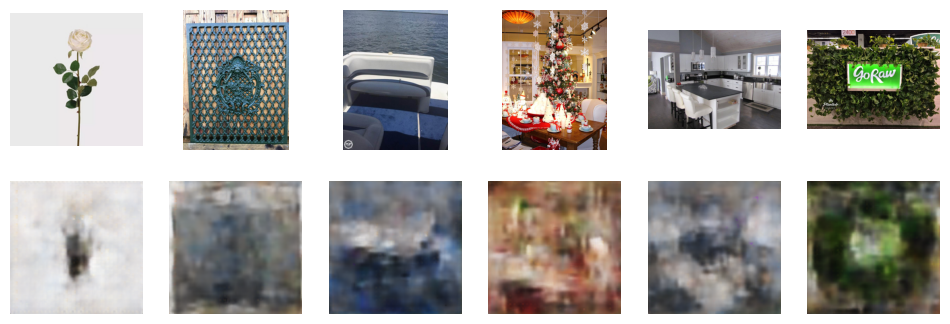

In [4]:
# PLT Оригиналы и реконструкции
img_count = 6
start_img = 6
fig, axs = plt.subplots(2, img_count, figsize=(img_count * 2, 4))
for i in range(start_img, img_count+start_img):
    axs[0, i-start_img].imshow(images_origin[i], cmap='gray')
    axs[0, i-start_img].axis('off')
    axs[1, i-start_img].imshow(images_reconstructed[i], cmap='gray')
    axs[1, i-start_img].axis('off')
plt.show()
